# Importing Packages

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
import imageio

In [2]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from customMetrics import dice_loss, dice_coef, iou

In [5]:
from gammaTransformation import transform_adaimg, green_adaimg

In [6]:
from sklearn.metrics import confusion_matrix

In [7]:
from patchify import patchify, unpatchify

In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Loading Utils Functions

In [9]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [24]:
def read_image(path):
    src = cv2.imread(path, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    x = cv2.cvtColor(green_adaimg(rgb), cv2.COLOR_RGB2BGR)
    
    top, bottom = [28] * 2
    left, right = [37,38]
    
    x = cv2.copyMakeBorder(x, top, bottom, left, right, cv2.BORDER_CONSTANT, value= 0)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

In [25]:
def read_gt(path):
    x = imageio.mimread(path)[0]  ## (128, 128)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

In [26]:
def load_data(path):
    x = sorted(glob(os.path.join(path, "images", "*.tif")))
    y = sorted(glob(os.path.join(path, "1st_manual", "*.gif")))
    return x, y

In [27]:
def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    cat_images = np.concatenate([ori_y, line, y_pred], axis=1)
    
    cv2.imwrite(save_image_path, cat_images)

In [28]:
def save_tests(y_pred, save_image_path):

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255


    cv2.imwrite(save_image_path, y_pred)

In [29]:
def get_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    sen = tp/(tp+fn)
    spe = tn/(tn+fp) 
    return sen, spe

# Setting The Environment

In [30]:
H = 584
W = 565

In [31]:
data_path = "D:\\Data sets\\DRIVE"

In [32]:
""" Save the results in this folder """
create_dir("results")

In [36]:
""" Load the model """
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("modelDir/model128_green.h5")


In [37]:
""" Load the dataset """
traindataset_path = os.path.join(data_path,"training")
train_x, train_y = load_data(traindataset_path)

testdataset_path = os.path.join(data_path,"test")
test_x, test_y = load_data(testdataset_path)

In [38]:
testdataset_path,len(test_x)

('D:\\Data sets\\DRIVE\\test', 20)

In [39]:
traindataset_path,len(train_x)

('D:\\Data sets\\DRIVE\\training', 20)

In [40]:
from matplotlib import pyplot as plt

# Training Scores

In [41]:
""" Make the prediction and calculate the metrics values """
SCORE = []

for x, y in tqdm(zip(train_x, train_y), total=len(train_x)):
    
    """ Extracting name """
    name = x.split("\\")[-1].split(".")[0]
    print(name)
    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_gt(y)
    
    print(ori_x.shape, ori_y.shape)
    
    patches_img = patchify(x, (128, 128,3), step=128)
    
    pred_patches = []
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):        
            single_patch_img = patches_img[i,j,:,:][0]
#             print(single_patch_img.shape)
            
            """ Prediction """
            y_pred = model.predict(np.expand_dims(single_patch_img, axis=0))[0]
            y_pred = y_pred > 0.5
            y_pred = y_pred.astype(np.int32)
            y_pred = np.squeeze(y_pred, axis=-1)
            
            pred_patches.append(y_pred)
    pred_patches_reshaped = np.reshape(pred_patches, (5, 5, 128,128) )
    reconstructed_image = unpatchify(pred_patches_reshaped, (640,640))
    
    final_y_pred = reconstructed_image[28:-28,37:-38]
    print(final_y_pred.shape)
#     plt.imshow(final_y_pred, cmap='gray')
    
    
    """ Saving the images """
    save_image_path = f"results\\{name}Train.png"
    print(save_image_path)

#     save_results(ori_x, ori_y, final_y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    final_y_pred = final_y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, final_y_pred)
    f1_value = f1_score(y, final_y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, final_y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, final_y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, final_y_pred, labels=[0, 1], average="binary")
    
    cm = confusion_matrix(y, final_y_pred)
    sensitivity, specificity = get_metrics(cm)
    
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, sensitivity, specificity])

  0%|                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

21_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\21_trainingTrain.png


  5%|███████▎                                                                                                                                         | 1/20 [00:59<18:45, 59.23s/it]

22_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\22_trainingTrain.png


 10%|██████████████▌                                                                                                                                  | 2/20 [01:01<07:43, 25.74s/it]

23_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\23_trainingTrain.png


 15%|█████████████████████▊                                                                                                                           | 3/20 [01:03<04:16, 15.06s/it]

24_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\24_trainingTrain.png


 20%|█████████████████████████████                                                                                                                    | 4/20 [01:06<02:39,  9.98s/it]

25_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\25_trainingTrain.png


 25%|████████████████████████████████████▎                                                                                                            | 5/20 [01:08<01:47,  7.18s/it]

26_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\26_trainingTrain.png


 30%|███████████████████████████████████████████▌                                                                                                     | 6/20 [01:10<01:16,  5.47s/it]

27_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\27_trainingTrain.png


 35%|██████████████████████████████████████████████████▊                                                                                              | 7/20 [01:12<00:58,  4.48s/it]

28_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\28_trainingTrain.png


 40%|██████████████████████████████████████████████████████████                                                                                       | 8/20 [01:15<00:45,  3.78s/it]

29_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\29_trainingTrain.png


 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 9/20 [01:17<00:37,  3.42s/it]

30_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\30_trainingTrain.png


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 10/20 [01:20<00:31,  3.18s/it]

31_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\31_trainingTrain.png


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 11/20 [01:22<00:26,  2.89s/it]

32_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\32_trainingTrain.png


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12/20 [01:24<00:21,  2.68s/it]

33_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\33_trainingTrain.png


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13/20 [01:27<00:17,  2.57s/it]

34_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\34_trainingTrain.png


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14/20 [01:29<00:14,  2.44s/it]

35_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\35_trainingTrain.png


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15/20 [01:31<00:12,  2.42s/it]

36_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\36_trainingTrain.png


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16/20 [01:34<00:10,  2.64s/it]

37_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\37_trainingTrain.png


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 17/20 [01:37<00:07,  2.62s/it]

38_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\38_trainingTrain.png


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 18/20 [01:39<00:05,  2.54s/it]

39_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\39_trainingTrain.png


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 19/20 [01:41<00:02,  2.45s/it]

40_training
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\40_trainingTrain.png


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:44<00:00,  5.21s/it]


In [42]:
SCORE

[['21_training',
  0.9693235543702267,
  0.7912559290575376,
  0.6546099774790145,
  0.7780030821640036,
  0.8049681101040618,
  0.7780030821640036,
  0.9847757302605289],
 ['22_training',
  0.9723542247545157,
  0.8477433569234878,
  0.7357244256453341,
  0.8519239155959609,
  0.8436036275454274,
  0.8519239155959609,
  0.9843145616706258],
 ['23_training',
  0.9811674142320281,
  0.8621133448719657,
  0.7576443057722309,
  0.8942595405791097,
  0.8321980893629782,
  0.8942595405791097,
  0.9872922459016925],
 ['24_training',
  0.9684628439810886,
  0.8561157047648018,
  0.7484285852432067,
  0.8098040754401109,
  0.9080456398674215,
  0.8098040754401109,
  0.9892537988763621],
 ['25_training',
  0.9520305491574736,
  0.6942630867297663,
  0.5317021213645374,
  0.5674634500615744,
  0.8940351226307149,
  0.5674634500615744,
  0.9928593219373029],
 ['26_training',
  0.9519911504424778,
  0.6372650042362209,
  0.46763677913698076,
  0.5046603561455046,
  0.8643930923096037,
  0.50466035

In [43]:

stat_df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Sensitivity", "Specificity"])
stat_df

,Image,Acc,F1,Jaccard,Recall,Precision,Sensitivity,Specificity
0,21_training,0.969324,0.791256,0.654610,0.778003,0.804968,0.778003,0.984776
1,22_training,0.972354,0.847743,0.735724,0.851924,0.843604,0.851924,0.984315
2,23_training,0.981167,0.862113,0.757644,0.894260,0.832198,0.894260,0.987292
3,24_training,0.968463,0.856116,0.748429,0.809804,0.908046,0.809804,0.989254
4,25_training,0.952031,0.694263,0.531702,0.567463,0.894035,0.567463,0.992859
5,26_training,0.951991,0.637265,0.467637,0.504660,0.864393,0.504660,0.992781
6,27_training,0.974215,0.853950,0.745124,0.855536,0.852370,0.855536,0.985682
7,28_training,0.973803,0.863955,0.760494,0.851651,0.876621,0.851651,0.987025
8,29_training,0.952994,0.687827,0.524189,0.615726,0.779054,0.615726,0.983965
9,30_training,0.937250,0.365675,0.223747,0.230567,0.883232,0.230567,0.997405


In [44]:
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")
print(f"Sensitivity: {score[5]:0.5f}")
print(f"Specificity: {score[6]:0.5f}")


Accuracy: 0.96698
F1: 0.78664
Jaccard: 0.66111
Recall: 0.76487
Precision: 0.83805
Sensitivity: 0.76487
Specificity: 0.98590


In [46]:
rows = ["Accuracy", "F1", "Jaccard", "Recall", "Precision", "Sensitivity", "Specificity"]

In [50]:
df = pd.read_csv("results/score.csv")
df

,Metrics,Model_128_2
0,Accuracy,0.968957
1,F1,0.800063
2,Jaccard,0.670754
3,Recall,0.738623
4,Precision,0.882897
5,Sensitivity,0.738623
6,Specificity,0.990655


In [53]:
df.insert(1,"Model_128_Green", score)
df

,Metrics,Model_128_Green,Model_128_2
0,Accuracy,0.966978,0.968957
1,F1,0.786639,0.800063
2,Jaccard,0.661114,0.670754
3,Recall,0.764865,0.738623
4,Precision,0.838047,0.882897
5,Sensitivity,0.764865,0.738623
6,Specificity,0.985900,0.990655


In [54]:
""" Saving """
df.to_csv("results/score.csv", index=False)

In [55]:
import seaborn as sns

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

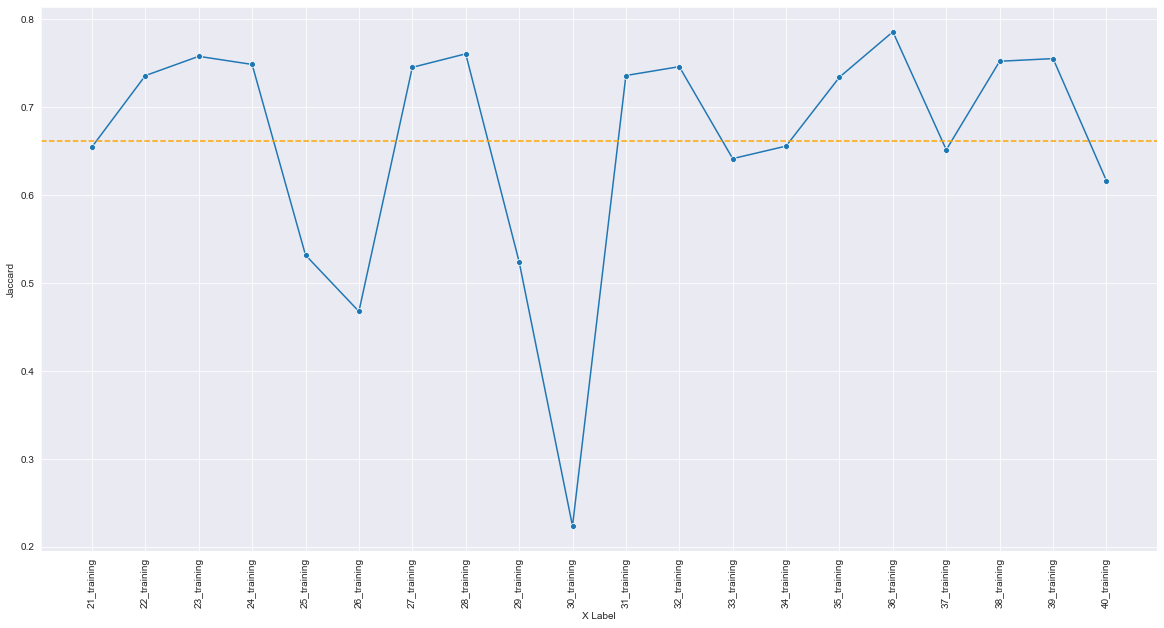

In [57]:
plt.figure(figsize=(20, 10))
sns.set_style("darkgrid")
ax = sns.lineplot(data=stat_df, x="Image", y="Jaccard", marker = "o")
ax.axhline(stat_df["Jaccard"].mean(), color="orange", linestyle="--")
ax.set(xlabel="X Label", ylabel = "Jaccard")
plt.setp(ax.get_xticklabels(), rotation=90)


# Test Results

In [58]:
""" Make the prediction and calculate the metrics values """
SCORE = []

for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    
    """ Extracting name """
    name = x.split("\\")[-1].split(".")[0]
    print(name)
    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_gt(y)
    
    print(ori_x.shape, ori_y.shape)
    
    patches_img = patchify(x, (128, 128,3), step=128)
    
    pred_patches = []
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):        
            single_patch_img = patches_img[i,j,:,:][0]
#             print(single_patch_img.shape)
            
            """ Prediction """
            y_pred = model.predict(np.expand_dims(single_patch_img, axis=0))[0]
            y_pred = y_pred > 0.5
            y_pred = y_pred.astype(np.int32)
            y_pred = np.squeeze(y_pred, axis=-1)
            
            pred_patches.append(y_pred)
    pred_patches_reshaped = np.reshape(pred_patches, (5, 5, 128,128) )
    reconstructed_image = unpatchify(pred_patches_reshaped, (640,640))
    
    final_y_pred = reconstructed_image[28:-28,37:-38]
    print(final_y_pred.shape)
#     plt.imshow(final_y_pred, cmap='gray')
    
    
    """ Saving the images """
    save_image_path = f"results\\{name}Test.png"
    print(save_image_path)

    save_results(ori_x, ori_y, final_y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    final_y_pred = final_y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, final_y_pred)
    f1_value = f1_score(y, final_y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, final_y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, final_y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, final_y_pred, labels=[0, 1], average="binary")
    
    cm = confusion_matrix(y, final_y_pred)
    sensitivity, specificity = get_metrics(cm)
    
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, sensitivity, specificity])

  0%|                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

01_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\01_testTest.png


  5%|███████▎                                                                                                                                         | 1/20 [00:03<00:57,  3.04s/it]

02_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\02_testTest.png


 10%|██████████████▌                                                                                                                                  | 2/20 [00:05<00:50,  2.83s/it]

03_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\03_testTest.png


 15%|█████████████████████▊                                                                                                                           | 3/20 [00:08<00:47,  2.79s/it]

04_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\04_testTest.png


 20%|█████████████████████████████                                                                                                                    | 4/20 [00:11<00:43,  2.74s/it]

05_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\05_testTest.png


 25%|████████████████████████████████████▎                                                                                                            | 5/20 [00:13<00:41,  2.75s/it]

06_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\06_testTest.png


 30%|███████████████████████████████████████████▌                                                                                                     | 6/20 [00:16<00:37,  2.71s/it]

07_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\07_testTest.png


 35%|██████████████████████████████████████████████████▊                                                                                              | 7/20 [00:19<00:34,  2.69s/it]

08_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\08_testTest.png


 40%|██████████████████████████████████████████████████████████                                                                                       | 8/20 [00:21<00:31,  2.66s/it]

09_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\09_testTest.png


 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 9/20 [00:24<00:29,  2.64s/it]

10_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\10_testTest.png


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 10/20 [00:26<00:26,  2.62s/it]

11_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\11_testTest.png


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 11/20 [00:29<00:24,  2.68s/it]

12_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\12_testTest.png


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12/20 [00:32<00:21,  2.67s/it]

13_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\13_testTest.png


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13/20 [00:36<00:20,  3.00s/it]

14_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\14_testTest.png


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14/20 [00:38<00:16,  2.82s/it]

15_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\15_testTest.png


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15/20 [00:40<00:13,  2.63s/it]

16_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\16_testTest.png


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16/20 [00:43<00:10,  2.51s/it]

17_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\17_testTest.png


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 17/20 [00:45<00:07,  2.40s/it]

18_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\18_testTest.png


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 18/20 [00:47<00:04,  2.32s/it]

19_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\19_testTest.png


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 19/20 [00:49<00:02,  2.32s/it]

20_test
(256,)
(640, 640, 3) (584, 565)
(584, 565)
results\20_testTest.png


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:51<00:00,  2.59s/it]


In [ ]:
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")
print(f"Sensitivity: {score[5]:0.5f}")
print(f"Specificity: {score[6]:0.5f}")